# Huấn luyện mô hình nhận dạng dấu thanh cho VSLR

Notebook này thực hiện huấn luyện mô hình LSTM và MLP để nhận dạng 5 dấu thanh tiếng Việt: huyền, sắc, hỏi, ngã, nặng thông qua các hành động tay.

## Các bước thực hiện:
1. Import thư viện và khởi tạo
2. Chuẩn bị dữ liệu keypoints
3. Xây dựng mô hình LSTM và MLP
4. Huấn luyện các mô hình
5. Đánh giá và so sánh kết quả
6. Lưu mô hình tốt nhất


## 1. Import thư viện và khởi tạo


In [1]:
import os
import sys
import time
import json
import pickle
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Add parent directory to path for imports
sys.path.append(str(Path().resolve().parent.parent.parent))

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


TensorFlow version: 2.9.0
NumPy version: 1.26.3


## 2. Định nghĩa DataProcessor và Models


In [2]:
class ToneDataProcessor:
    """Class xử lý dữ liệu dấu thanh"""
    
    def __init__(self, data_dir: str):
        """
        Khởi tạo ToneDataProcessor
        
        Args:
            data_dir (str): Thư mục dữ liệu
        """
        self.data_dir = Path(data_dir)
        self.keypoints_dir = self.data_dir / "keypoints"
        
        # Các lớp dấu thanh
        self.classes = ['hoi', 'huyen', 'nang', 'nga', 'sac']
        self.class_names = {
            'hoi': 'Hỏi',
            'huyen': 'Huyền', 
            'nang': 'Nặng',
            'nga': 'Ngã',
            'sac': 'Sắc'
        }
        
        # Label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.classes)
    
    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Tải dữ liệu từ thư mục keypoints
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: (X, y) - features và labels
        """
        X_list = []
        y_list = []
        
        print("Loading tone data...")
        
        for class_name in self.classes:
            class_dir = self.keypoints_dir / class_name
            if not class_dir.exists():
                print(f"Warning: Class directory {class_dir} not found")
                continue
            
            class_idx = self.label_encoder.transform([class_name])[0]
            npy_files = list(class_dir.glob("*.npy"))
            
            print(f"Loading {len(npy_files)} samples for class {class_name}")
            
            for npy_file in npy_files:
                try:
                    keypoints = np.load(npy_file)
                    
                    # Kiểm tra shape
                    if keypoints.shape == (30, 63):
                        X_list.append(keypoints)
                        y_list.append(class_idx)
                    else:
                        print(f"Warning: Invalid shape {keypoints.shape} in {npy_file}")
                
                except Exception as e:
                    print(f"Error loading {npy_file}: {e}")
        
        if not X_list:
            raise ValueError("No valid data found!")
        
        X = np.array(X_list)
        y = np.array(y_list)
        
        print(f"Loaded {len(X)} samples with shape {X.shape}")
        return X, y
    
    def preprocess_data(self, X: np.ndarray, y: np.ndarray, 
                       test_size: float = 0.2, random_state: int = 42) -> Tuple:
        """
        Tiền xử lý dữ liệu
        
        Args:
            X (np.ndarray): Features
            y (np.ndarray): Labels
            test_size (float): Tỷ lệ test set
            random_state (int): Random seed
            
        Returns:
            Tuple: (X_train, X_test, y_train, y_test, y_train_cat, y_test_cat)
        """
        print("Preprocessing data...")
        
        # Chia train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # One-hot encoding
        y_train_cat = to_categorical(y_train, num_classes=len(self.classes))
        y_test_cat = to_categorical(y_test, num_classes=len(self.classes))
        
        print(f"Train set: {X_train.shape}, {y_train_cat.shape}")
        print(f"Test set: {X_test.shape}, {y_test_cat.shape}")
        
        return X_train, X_test, y_train, y_test, y_train_cat, y_test_cat


In [3]:
class ToneLSTMModel:
    """LSTM model cho nhận dạng dấu thanh"""
    
    def __init__(self, input_shape: Tuple[int, int], num_classes: int = 5):
        """
        Khởi tạo ToneLSTMModel
        
        Args:
            input_shape (Tuple[int, int]): Shape đầu vào (sequence_length, features)
            num_classes (int): Số lớp
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
    
    def create_model(self) -> Model:
        """Tạo mô hình LSTM"""
        print("Creating LSTM model...")
        
        # Input layer
        inputs = Input(shape=self.input_shape, name='input_layer')
        
        # LSTM layers
        x = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
        x = BatchNormalization()(x)
        
        x = LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
        x = BatchNormalization()(x)
        
        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Output layer
        outputs = Dense(self.num_classes, activation='softmax', name='output_layer')(x)
        
        # Create model
        self.model = Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model
    
    def get_model_summary(self):
        """In thông tin mô hình"""
        if self.model is None:
            print("Model not created yet!")
            return
        
        self.model.summary()
        
        # Tính số parameters
        total_params = self.model.count_params()
        print(f"\nTotal parameters: {total_params:,}")

class ToneMLPModel:
    """MLP model cho nhận dạng dấu thanh"""
    
    def __init__(self, input_shape: int, num_classes: int = 5):
        """
        Khởi tạo ToneMLPModel
        
        Args:
            input_shape (int): Số features đầu vào (flattened)
            num_classes (int): Số lớp
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
    
    def create_model(self) -> Model:
        """Tạo mô hình MLP"""
        print("Creating MLP model...")
        
        # Input layer
        inputs = Input(shape=(self.input_shape,), name='input_layer')
        
        # Dense layers
        x = Dense(512, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        
        # Output layer
        outputs = Dense(self.num_classes, activation='softmax', name='output_layer')(x)
        
        # Create model
        self.model = Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model


## 3. Thiết lập tham số và chuẩn bị dữ liệu


In [4]:
# Thiết lập tham số
data_dir = "../../data/tones"
model_dir = "../../trained_models"
batch_size = 32
epochs = 100

# Tạo thư mục model
os.makedirs(model_dir, exist_ok=True)

print("=== THÔNG TIN THAM SỐ ===")
print(f"Data directory: {data_dir}")
print(f"Model directory: {model_dir}")
print(f"Batch size: {batch_size}")
print(f"Number of epochs: {epochs}")


=== THÔNG TIN THAM SỐ ===
Data directory: ../../data/tones
Model directory: ../../trained_models
Batch size: 32
Number of epochs: 100


In [5]:
# Khởi tạo DataProcessor và tải dữ liệu
print("Initializing data processor...")
data_processor = ToneDataProcessor(data_dir)

# Tải dữ liệu
X, y = data_processor.load_data()

# Tiền xử lý dữ liệu
X_train, X_test, y_train, y_test, y_train_cat, y_test_cat = data_processor.preprocess_data(X, y)

# Tạo MLP data (flatten)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nLSTM input shape: {X_train.shape}")
print(f"MLP input shape: {X_train_flat.shape}")
print(f"Number of classes: {len(data_processor.classes)}")
print(f"Classes: {list(data_processor.class_names.values())}")


Initializing data processor...
Loading tone data...
Loading 80 samples for class hoi
Loading 80 samples for class huyen
Loading 80 samples for class nang
Loading 80 samples for class nga
Loading 80 samples for class sac
Loaded 400 samples with shape (400, 30, 63)
Preprocessing data...
Train set: (320, 30, 63), (320, 5)
Test set: (80, 30, 63), (80, 5)

LSTM input shape: (320, 30, 63)
MLP input shape: (320, 1890)
Number of classes: 5
Classes: ['Hỏi', 'Huyền', 'Nặng', 'Ngã', 'Sắc']


## 4. Tạo và huấn luyện mô hình LSTM


In [6]:
# Tạo mô hình LSTM
print("="*50)
print("Training LSTM Model")
print("="*50)

lstm_model = ToneLSTMModel(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=len(data_processor.classes)
)
model = lstm_model.create_model()
lstm_model.get_model_summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'lstm_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("Starting LSTM training...")
start_time = time.time()

lstm_history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"LSTM training completed in {training_time:.2f} seconds")

# Lưu final model
model.save(os.path.join(model_dir, 'lstm_model_final.h5'))
print("LSTM model saved!")


Training LSTM Model
Creating LSTM model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 30, 63)]          0         
                                                                 
 lstm (LSTM)                 (None, 30, 128)           98304     
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)    

## 5. Tạo và huấn luyện mô hình MLP


In [7]:
# Tạo mô hình MLP
print("="*50)
print("Training MLP Model")
print("="*50)

mlp_model = ToneMLPModel(
    input_shape=X_train_flat.shape[1],
    num_classes=len(data_processor.classes)
)
model = mlp_model.create_model()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'mlp_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("Starting MLP training...")
start_time = time.time()

mlp_history = model.fit(
    X_train_flat, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_flat, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"MLP training completed in {training_time:.2f} seconds")

# Lưu final model
model.save(os.path.join(model_dir, 'mlp_model_final.h5'))
print("MLP model saved!")


Training MLP Model
Creating MLP model...
Starting MLP training...
Epoch 1/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.5874 - accuracy: 0.8281
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to ../../trained_models\mlp_best.h5
10/10 [==============================] - 1s 30ms/step - loss: 0.4867 - accuracy: 0.8594 - val_loss: 2.8518 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 0.9861
Epoch 2: val_accuracy improved from 0.20000 to 0.25000, saving model to ../../trained_models\mlp_best.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0598 - accuracy: 0.9875 - val_loss: 3.0325 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.25000
10/10 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 2.798

## 6. Đánh giá và so sánh các mô hình


In [8]:
# Đánh giá các mô hình
print("="*50)
print("Evaluating Models")
print("="*50)

# Đánh giá LSTM
print("\nLSTM Model Evaluation:")
lstm_loss, lstm_acc = lstm_model.model.evaluate(
    X_test, y_test_cat, verbose=0
)
print(f"LSTM - Loss: {lstm_loss:.4f}, Accuracy: {lstm_acc:.4f}")

# Predictions LSTM
lstm_pred = lstm_model.model.predict(X_test)
lstm_pred_classes = np.argmax(lstm_pred, axis=1)

# Classification report LSTM
print("\nLSTM Classification Report:")
print(classification_report(
    y_test, lstm_pred_classes, 
    target_names=list(data_processor.class_names.values())
))

# Đánh giá MLP
print("\nMLP Model Evaluation:")
mlp_loss, mlp_acc = mlp_model.model.evaluate(
    X_test_flat, y_test_cat, verbose=0
)
print(f"MLP - Loss: {mlp_loss:.4f}, Accuracy: {mlp_acc:.4f}")

# Predictions MLP
mlp_pred = mlp_model.model.predict(X_test_flat)
mlp_pred_classes = np.argmax(mlp_pred, axis=1)

# Classification report MLP
print("\nMLP Classification Report:")
print(classification_report(
    y_test, mlp_pred_classes, 
    target_names=list(data_processor.class_names.values())
))


Evaluating Models

LSTM Model Evaluation:
LSTM - Loss: 0.0241, Accuracy: 1.0000
3/3 [==============================] - 0s 8ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

         Hỏi       1.00      1.00      1.00        16
       Huyền       1.00      1.00      1.00        16
        Nặng       1.00      1.00      1.00        16
         Ngã       1.00      1.00      1.00        16
         Sắc       1.00      1.00      1.00        16

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


MLP Model Evaluation:
MLP - Loss: 0.0363, Accuracy: 1.0000
3/3 [==============================] - 0s 0s/step

MLP Classification Report:
              precision    recall  f1-score   support

         Hỏi       1.00      1.00      1.00        16
       Huyền       1.00      1.00      1.00        16
        Nặng       1.00      1.00      1.00       

## 7. Vẽ biểu đồ Confusion Matrix


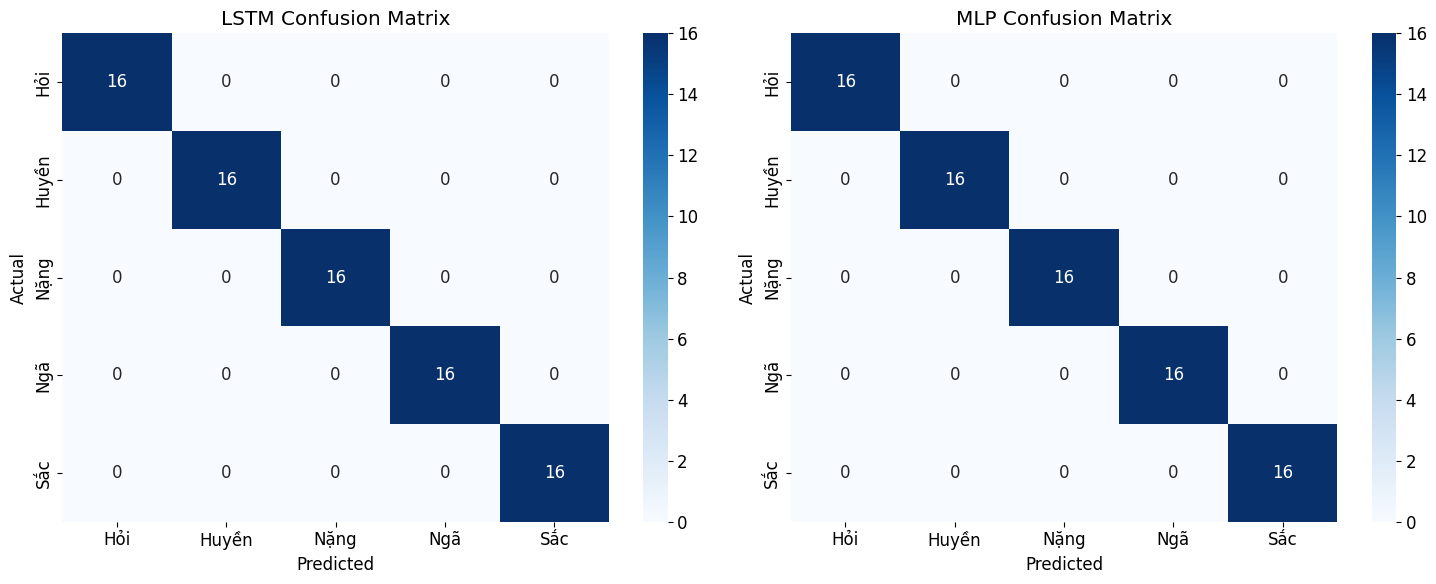

In [9]:
# Vẽ Confusion Matrix cho cả hai mô hình
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

class_names = list(data_processor.class_names.values())

# LSTM Confusion Matrix
cm_lstm = confusion_matrix(y_test, lstm_pred_classes)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=class_names, yticklabels=class_names)
ax1.set_title('LSTM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, mlp_pred_classes)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=ax2,
           xticklabels=class_names, yticklabels=class_names)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'tone_confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()


## 8. Vẽ biểu đồ Training History


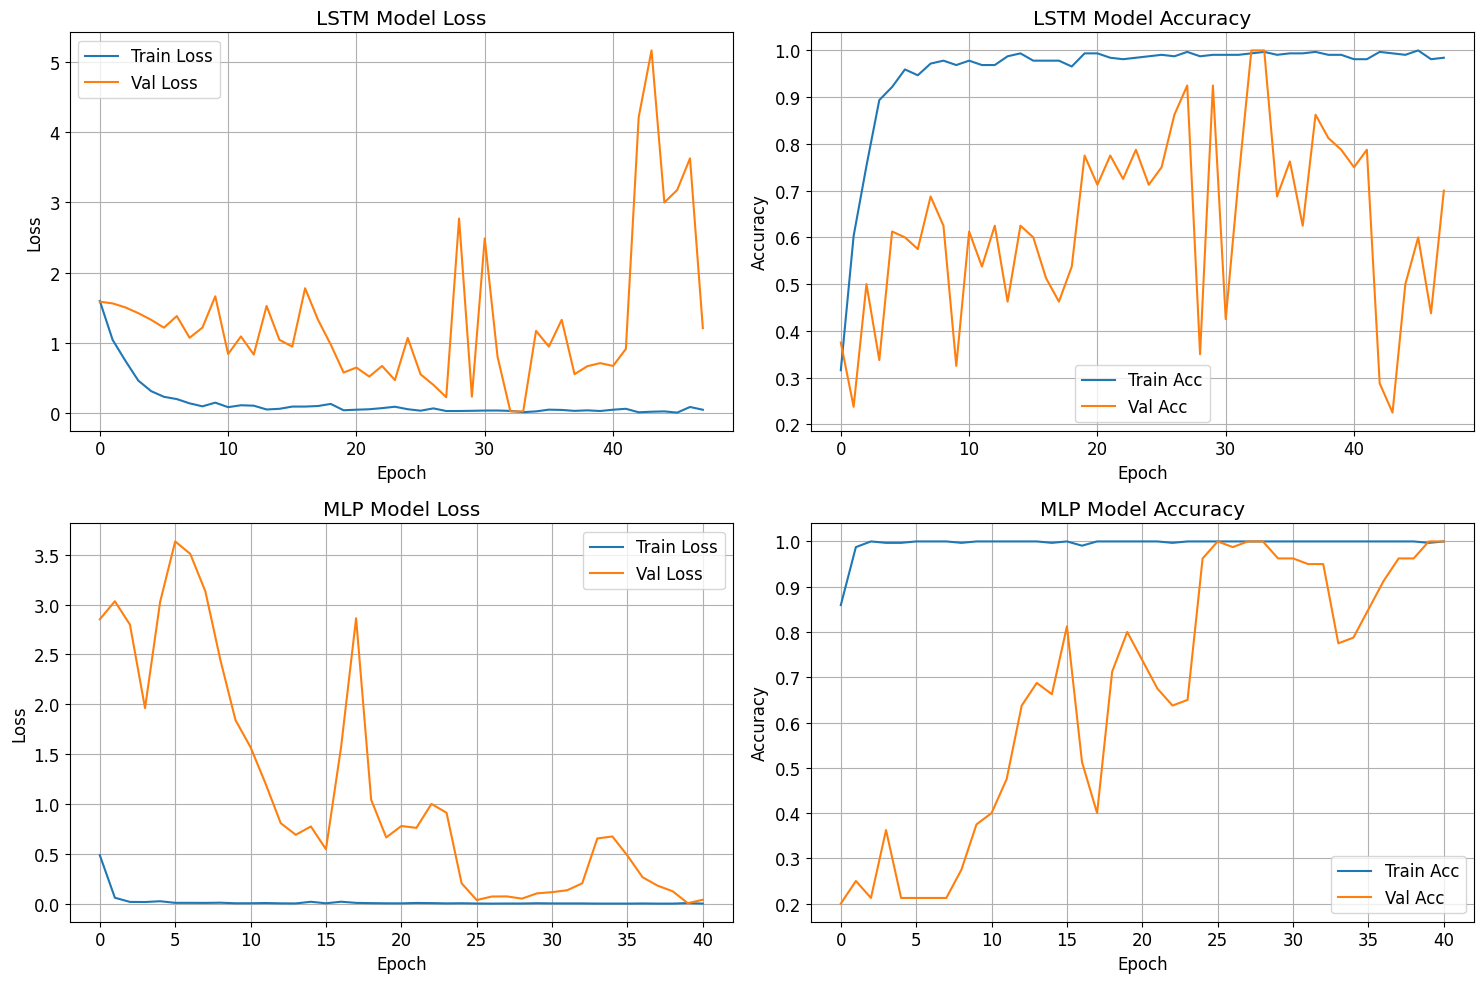

In [10]:
# Vẽ biểu đồ training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# LSTM plots
# Loss
axes[0, 0].plot(lstm_history.history['loss'], label='Train Loss')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('LSTM Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(lstm_history.history['accuracy'], label='Train Acc')
axes[0, 1].plot(lstm_history.history['val_accuracy'], label='Val Acc')
axes[0, 1].set_title('LSTM Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# MLP plots
# Loss
axes[1, 0].plot(mlp_history.history['loss'], label='Train Loss')
axes[1, 0].plot(mlp_history.history['val_loss'], label='Val Loss')
axes[1, 0].set_title('MLP Model Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy
axes[1, 1].plot(mlp_history.history['accuracy'], label='Train Acc')
axes[1, 1].plot(mlp_history.history['val_accuracy'], label='Val Acc')
axes[1, 1].set_title('MLP Model Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'tone_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()


## 9. So sánh hiệu suất và lưu mô hình tốt nhất


=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===
LSTM - Test Accuracy: 1.0000, Test Loss: 0.0241
MLP  - Test Accuracy: 1.0000, Test Loss: 0.0363

🏆 Mô hình tốt nhất: MLP (Accuracy: 1.0000)


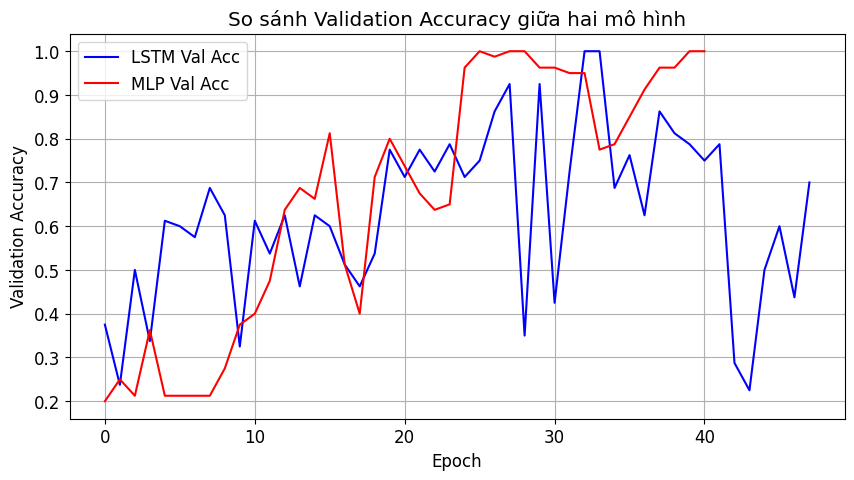

In [11]:
# So sánh hiệu suất hai mô hình
print("=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===")
print(f"LSTM - Test Accuracy: {lstm_acc:.4f}, Test Loss: {lstm_loss:.4f}")
print(f"MLP  - Test Accuracy: {mlp_acc:.4f}, Test Loss: {mlp_loss:.4f}")

# Xác định mô hình tốt nhất
best_model_name = 'LSTM' if lstm_acc > mlp_acc else 'MLP'
best_accuracy = max(lstm_acc, mlp_acc)

print(f"\n🏆 Mô hình tốt nhất: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# Vẽ biểu đồ so sánh accuracy
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc', color='blue')
plt.plot(mlp_history.history['val_accuracy'], label='MLP Val Acc', color='red')
plt.title('So sánh Validation Accuracy giữa hai mô hình')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'tone_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


## 10. Lưu label encoder và tóm tắt kết quả


In [12]:
# Lưu label encoder
encoder_path = os.path.join(model_dir, 'lstm_model_label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(data_processor.label_encoder, f)
print(f"Label encoder saved to {encoder_path}")

print("\n=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN MÔ HÌNH DẤU THANH ===")
print(f"\n📊 Thống kê dữ liệu:")
print(f"  - Tổng số mẫu: {len(X)}")
print(f"  - Số lớp: {len(data_processor.classes)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Classes: {list(data_processor.class_names.values())}")

print(f"\n🤖 Kết quả mô hình:")
print(f"  - LSTM Accuracy: {lstm_acc:.4f}")
print(f"  - MLP Accuracy: {mlp_acc:.4f}")
print(f"  - Mô hình tốt nhất: {best_model_name}")

print(f"\n💾 Mô hình đã được lưu tại:")
print(f"  - LSTM best: {os.path.join(model_dir, 'lstm_best.h5')}")
print(f"  - LSTM final: {os.path.join(model_dir, 'lstm_model_final.h5')}")
print(f"  - MLP best: {os.path.join(model_dir, 'mlp_best.h5')}")
print(f"  - MLP final: {os.path.join(model_dir, 'mlp_model_final.h5')}")
print(f"  - Label encoder: {encoder_path}")
print(f"  - Confusion matrices: {os.path.join(model_dir, 'tone_confusion_matrices.png')}")
print(f"  - Training history: {os.path.join(model_dir, 'tone_training_history.png')}")
print(f"  - Model comparison: {os.path.join(model_dir, 'tone_model_comparison.png')}")

print(f"\n🎯 Bước tiếp theo:")
print(f"  - Sử dụng mô hình tốt nhất ({best_model_name}) trong ứng dụng nhận dạng dấu thanh")
print(f"  - Hoặc tiếp tục fine-tuning với dữ liệu mới")


Label encoder saved to ../../trained_models\lstm_model_label_encoder.pkl

=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN MÔ HÌNH DẤU THANH ===

📊 Thống kê dữ liệu:
  - Tổng số mẫu: 400
  - Số lớp: 5
  - Training samples: 320
  - Test samples: 80
  - Classes: ['Hỏi', 'Huyền', 'Nặng', 'Ngã', 'Sắc']

🤖 Kết quả mô hình:
  - LSTM Accuracy: 1.0000
  - MLP Accuracy: 1.0000
  - Mô hình tốt nhất: MLP

💾 Mô hình đã được lưu tại:
  - LSTM best: ../../trained_models\lstm_best.h5
  - LSTM final: ../../trained_models\lstm_model_final.h5
  - MLP best: ../../trained_models\mlp_best.h5
  - MLP final: ../../trained_models\mlp_model_final.h5
  - Label encoder: ../../trained_models\lstm_model_label_encoder.pkl
  - Confusion matrices: ../../trained_models\tone_confusion_matrices.png
  - Training history: ../../trained_models\tone_training_history.png
  - Model comparison: ../../trained_models\tone_model_comparison.png

🎯 Bước tiếp theo:
  - Sử dụng mô hình tốt nhất (MLP) trong ứng dụng nhận dạng dấu thanh
  - Hoặc tiếp tụ